In [1]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models

  Cloning https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to /tmp/pip-req-build-obla383j
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models /tmp/pip-req-build-obla383j
  Resolved https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to commit 975885b1f6814fd5958199919b33e02a6a9aa152
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 4.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 92.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import matplotlib as mpl

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, initializers,regularizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import to_categorical

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# (batch_size, 28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_valid = np.expand_dims(X_valid, -1)

# Convertir las etiquetas a one-hot encoding
num_classes = 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid, num_classes=num_classes)

In [5]:
X_train.shape
y_train.shape

(55000,)

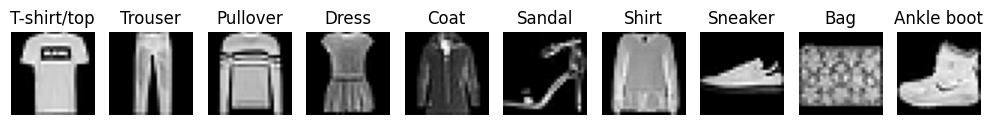

In [6]:
plt.figure(figsize=(10, 5))
"""
Crea una nueva figura de tamaño 10x5 pulgadas.

Parameters
----------
figsize : tuple of float, optional, default: (10, 5)
    El tamaño de la figura en pulgadas. El primer valor es el ancho y el segundo es la altura.
"""

# Etiquetas de las categorías para los datos a visualizar
categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
"""
categories : list of str
    Lista de etiquetas que corresponden a cada clase en los datos. Cada etiqueta describe una categoría de las imágenes de ropa y calzado.
"""

# Iterar a través de las 10 categorías
for i in range(10):
    """
    Para cada categoría, selecciona el primer ejemplo correspondiente a esa clase y genera un subgráfico para mostrarlo.

    Parameters
    ----------
    i : int
        Índice de la categoría actual en el bucle, que varía de 0 a 9.
    """

    # Encontrar el primer ejemplo de la categoría actual
    example_index = np.where(y_train == i)[0][0]
    """
    Busca la primera ocurrencia del índice de la categoría `i` en los datos de entrenamiento `y_train`.

    Returns
    -------
    example_index : int
        Índice del primer ejemplo en `y_train` que pertenece a la categoría `i`.
    """

    image = X_train[example_index]
    """
    Extrae la imagen correspondiente al `example_index` encontrado de los datos de entrenamiento `X_train`.

    Returns
    -------
    image : ndarray
        Arreglo 2D que representa la imagen en escala de grises para la categoría `i`.
    """

    # Configurar un subgráfico para cada categoría
    plt.subplot(1, 10, i + 1)
    """
    Crea un subgráfico en la figura actual con 1 fila y 10 columnas, colocando la imagen en la posición `i + 1`.

    Parameters
    ----------
    nrows : int
        Número de filas de subgráficos (1 en este caso).
    ncols : int
        Número de columnas de subgráficos (10 en este caso).
    index : int
        Índice de la posición actual del subgráfico (de 1 a 10).
    """

    plt.imshow(image, cmap='gray')
    """
    Muestra la imagen en el subgráfico usando una escala de grises.

    Parameters
    ----------
    image : ndarray
        Imagen que se mostrará.
    cmap : str, optional
        Mapa de colores utilizado para mostrar la imagen. En este caso, 'gray' para mostrar la imagen en escala de grises.
    """

    plt.title(categories[i])
    """
    Asigna el título correspondiente a la categoría actual (`categories[i]`).

    Parameters
    ----------
    title : str
        El título de cada subgráfico, que corresponde a la categoría de la imagen.
    """

    plt.axis('off')
    """
    Desactiva los ejes del subgráfico para una visualización más limpia.
    """

plt.tight_layout()
"""
Ajusta automáticamente el espaciado entre los subgráficos para evitar solapamientos.

Parameters
----------
tight_layout : function
    Optimiza la disposición de los subgráficos para que no se superpongan.
"""

plt.show()



In [7]:
@tf.keras.utils.register_keras_serializable()
class Sampling(tf.keras.layers.Layer):
    """
    Capa personalizada de TensorFlow que implementa la técnica de muestreo reparametrizado utilizada en modelos como 
    variational autoencoders (VAE). Permite muestrear desde una distribución normal con media `z_mean` y varianza logarítmica `z_log_var`.

    Methods
    -------
    call(inputs)
        Realiza el muestreo reparametrizado a partir de los parámetros de entrada `z_mean` y `z_log_var`.
    """
    
    ########################################################################
    # ----------------------------------------------------------------------
    def call(self, inputs):
        """
        Realiza el paso de muestreo utilizando la técnica de reparametrización.

        Dado `z_mean` (la media) y `z_log_var` (el logaritmo de la varianza), esta función muestrea valores latentes `z`
        de una distribución gaussiana utilizando el truco de reparametrización, es decir, `z = z_mean + epsilon * sigma`, 
        donde `epsilon` es ruido gaussiano estándar y `sigma` es la desviación estándar derivada de `z_log_var`.

        Parameters
        ----------
        inputs : tuple of tf.Tensor
            Una tupla que contiene dos tensores:
            - `z_mean` : tf.Tensor
                Tensor que representa las medias de la distribución latente. Su forma es `(batch_size, dim)`.
            - `z_log_var` : tf.Tensor
                Tensor que representa el logaritmo de las varianzas de la distribución latente. Su forma es `(batch_size, dim)`.

        Returns
        -------
        z : tf.Tensor
            El tensor muestreado de la distribución reparametrizada con la misma forma que `z_mean`, es decir, `(batch_size, dim)`.

        """
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        # Generar un tensor de ruido gaussiano epsilon de la misma forma que z_mean
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        """
        Genera un tensor de ruido gaussiano estándar (media 0, desviación estándar 1) con las dimensiones del lote `batch`
        y la dimensionalidad latente `dim`. Este ruido es utilizado para realizar el truco de reparametrización.
        
        Returns
        -------
        epsilon : tf.Tensor
            Tensor de ruido gaussiano de forma `(batch_size, dim)`.
        """

        # Realizar el truco de reparametrización: z = z_mean + sigma * epsilon
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
        """
        Aplica la fórmula de reparametrización para obtener `z`, el valor muestreado de la distribución latente.
        
        Returns
        -------
        z : tf.Tensor
            El valor muestreado de la distribución latente con la misma forma que `z_mean`, `(batch_size, dim)`.
        """


In [8]:
def plot_mnist_autoencoder(x, x_, y=None, y_=None, cmap='gray', vmin=0, vmax=1):
    """
    Muestra las imágenes originales y las imágenes reconstruidas del conjunto de datos MNIST utilizando un autoencoder. 
    Incluye etiquetas verdaderas y predichas si se proporcionan.

    Parámetros
    ----------
    x : Sequence[np.ndarray]
        Imágenes originales del conjunto de datos.
    x_ : Sequence[np.ndarray]
        Imágenes reconstruidas por el autoencoder.
    y : Optional[Sequence], opcional
        Etiquetas verdaderas de las imágenes, por defecto None.
    y_ : Optional[Sequence], opcional
        Etiquetas predichas de las imágenes, por defecto None.
    cmap : str, opcional
        Mapa de colores para las imágenes, por defecto 'gray' (escala de grises).
    vmin : float, opcional
        Valor mínimo para la normalización de los píxeles, por defecto 0.
    vmax : float, opcional
        Valor máximo para la normalización de los píxeles, por defecto 1.

    Descripción
    -----------
    Esta función muestra dos filas de imágenes:
    
    - La primera fila contiene las imágenes originales `x` del conjunto de datos MNIST.
    - La segunda fila contiene las imágenes reconstruidas `x_` generadas por un autoencoder.
    
    Si las etiquetas verdaderas (`y`) y predichas (`y_`) se proporcionan, se mostrarán encima de las imágenes:
    
    - Las etiquetas verdaderas se muestran en la primera fila como 'True: {y[i]}'.
    - Las etiquetas predichas se muestran en la segunda fila como 'Pred: {y_[i]}'.
    - El título de la etiqueta predicha cambia de color: rojo si la predicción es incorrecta (solo si se proporcionan `y` y `y_`), verde si es correcta.

    """
    plt.figure(figsize=(20, 4))
    num_images = len(x)
    
    for i in range(num_images):
        # Mostrar imagen original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x[i].reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        if y is not None:
            plt.title(f'Verdadero: {y[i]}')
        plt.axis('off')
        
        # Mostrar imagen reconstruida
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(x_[i].reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        if y_ is not None:
            color = "red" if y is not None and y[i] != y_[i] else 'green'
            plt.title(f'Predicho: {y_[i]}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [9]:
def compare_images(original_images, predicted_images, true_labels, label_names, indices, figsize=(10, 5)):
    """
    Función para comparar visualmente imágenes originales con las predicciones, mostrando también las etiquetas verdaderas.
    Args:
    original_images (numpy.array): Array de imágenes originales.
    predicted_images (numpy.array): Array de imágenes reconstruidas por el modelo, con la forma (n_samples, height, width, channels).
    true_labels (numpy.array): Array de etiquetas verdaderas para las imágenes originales.
    label_names (list): Lista de nombres de etiquetas correspondientes a las clases.
    indices (list of int): Lista de índices de las imágenes a comparar.
    figsize (tuple): Tamaño de la figura de matplotlib.
    """
    plt.figure(figsize=figsize)
    num_images = len(indices)

    for i, index in enumerate(indices):
        # Mostrar imagen original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[index].squeeze(), cmap='gray')
        plt.title(f'Original {index}\nLabel: {label_names[true_labels[index]]}')
        plt.axis('off')

        # Mostrar imagen predicha
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(predicted_images[index].squeeze(), cmap='gray')
        plt.title(f'Reconstrucción {index}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### Maximum Mean Discrepancy (MMD)

La **Maximum Mean Discrepancy (MMD)** es una medida estadística que cuantifica la diferencia entre dos distribuciones de probabilidad $(\mathbb{P})$ y $(\mathbb{Q})$ a partir de sus embeddings en un espacio de Hilbert con núcleo reproducible (RKHS) asociado a un kernel $(k)$.

#### Definición:
Para un kernel $(k: \mathcal{X} \times \mathcal{X} \to \mathbb{R})$, las embeddings medias de $(\mathbb{P})$ y $(\mathbb{Q})$ en el RKHS $(\mathcal{H}_k)$ son $(\mu_\mathbb{P} := \mathbb{E}[k(\cdot, X)])$ y $(\mu_\mathbb{Q} := \mathbb{E}[k(\cdot, Y)])$, donde $(X \sim \mathbb{P})$ y $(Y \sim \mathbb{Q})$.

La MMD se define como la norma de la diferencia entre estas embeddings:

$$
\text{MMD}(\mathbb{P}, \mathbb{Q}; \mathcal{H}_k) = \|\mu_\mathbb{P} - \mu_\mathbb{Q}\|_{\mathcal{H}_k}
$$

Esto equivale a:

$$
\text{MMD}(\mathbb{P}, \mathbb{Q}; \mathcal{H}_k) = \sqrt{\mathbb{E}[k(X, X')] + \mathbb{E}[k(Y, Y')] - 2\mathbb{E}[k(X, Y)]}
$$

#### Propiedades:
- **Kernels característicos**: Si el kernel es característico, $( \text{MMD}(\mathbb{P}, \mathbb{Q}; \mathcal{H}_k) = 0)$ implica que $( \mathbb{P} = \mathbb{Q})$, y $( \text{MMD} > 0)$ implica una diferencia entre $( \mathbb{P})$ y $( \mathbb{Q})$.
- **Aplicaciones**: La MMD se utiliza en pruebas de hipótesis no paramétricas, evaluación de modelos generativos y aprendizaje no supervisado.


In [10]:
def mmd_loss(y_true, y_pred):
    """
    Calcula la pérdida MMD entre y_true y y_pred.

    y_true: etiquetas verdaderas (one-hot vectors)
    y_pred: etiquetas predichas (probabilidades softmax)
    """
    # Asegurarse de que y_true y y_pred son tensores de tipo float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Definir kernel Gaussiano
    def gaussian_kernel_matrix(x, y, sigma=1.0):
        x_size = tf.shape(x)[0]
        y_size = tf.shape(y)[0]
        dim = tf.shape(x)[1]
        x = tf.reshape(x, [x_size, 1, dim])
        y = tf.reshape(y, [1, y_size, dim])
        kernel = tf.exp(-tf.reduce_sum(tf.square(x - y), axis=2) / (2 * sigma ** 2))
        return kernel

    # Calcular las matrices de kernel
    K_yy = gaussian_kernel_matrix(y_true, y_true)
    K_ff = gaussian_kernel_matrix(y_pred, y_pred)
    K_yf = gaussian_kernel_matrix(y_true, y_pred)

    # Calcular la MMD
    mmd = tf.reduce_mean((K_yy) + (K_ff) - 2 * (K_yf))

    return mmd

# Funciones de pérdida
def reconstruction_loss(inputs, outputs):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs)))

def dkl_loss(inputs, outputs):
    z_mean, z_log_var = outputs[..., 0], outputs[..., 1]
    return - tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))


In [11]:
import tensorflow as tf

# Definir el modelo
def model_class(input_shape=(28, 28, 1), num_classes=10, latent_dim=128):
    """
    Define un modelo de autoencoder variacional (VAE) con un clasificador incorporado. 
    El modelo tiene una arquitectura de encoder-decoder, donde se generan representaciones latentes 
    y se reconstruyen las imágenes, mientras que también se produce una salida de clasificación softmax.

    Parámetros
    ----------
    input_shape : tuple, opcional
        Forma de la entrada, generalmente las dimensiones de las imágenes MNIST (28x28x1). Por defecto (28, 28, 1).
    num_classes : int, opcional
        Número de clases para la clasificación (MNIST tiene 10 clases). Por defecto 10.
    latent_dim : int, opcional
        Dimensión de la representación latente en el VAE. Por defecto 128.

    Returns
    -------
    vae : tf.keras.Model
        Un modelo de autoencoder variacional (VAE) con salida de reconstrucción, 
        representación gaussiana latente y salida softmax para la clasificación.

    Descripción
    -----------
    El modelo está compuesto de las siguientes partes:

    1. **Encoder**:
       - Conv2D y AveragePooling2D para extraer características de las imágenes de entrada.
       - `Dropout` para regularización.
       - `z_mean` y `z_log_var` para representar la media y varianza logarítmica de la distribución latente.
       - `Sampling` es una capa personalizada que usa el truco de reparametrización para muestrear del espacio latente.
       - `softmax_output` para la clasificación.

    2. **Decoder**:
       - Densas y capas `Conv2DTranspose` para reconstruir las imágenes a partir de la representación latente.
       - `UpSampling2D` para restaurar las dimensiones originales.
       - `reconstruction` es la salida final de la imagen reconstruida.

    3. **Modelo VAE**:
       - El modelo final tiene tres salidas: la imagen reconstruida (`reconstruction`), 
         la concatenación de `z_mean` y `z_log_var` (`z_gaussian`), y la clasificación (`softmax_output`).

    """
    # Encoder
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(6, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=12),
                               padding='same', name='conv1')(inputs)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=23),
                               padding='same', name='conv2')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(120, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=52),
                               padding='same', name='conv3')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.15)(x)

    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z_gaussian = tf.keras.layers.Concatenate(name='z_gaussian', axis=-1)([z_mean, z_log_var])
    z = Sampling()([z_mean, z_log_var])  # Capa de muestreo para el truco de reparametrización

    softmax_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='softmax_output')(z)

    # Decoder
    x = tf.keras.layers.Dense(7 * 7 * 16, activation='selu')(z)
    x = tf.keras.layers.Reshape((7, 7, 16))(x)
    x = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation='selu',
                                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=12),
                                        padding='same')(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(6, kernel_size=3, activation='selu',
                                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=23),
                                        padding='same', name='conv2Transpose')(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    reconstruction = tf.keras.layers.Conv2D(input_shape[2], kernel_size=3, padding='same',
                                            activation='sigmoid', name='reconstruction')(x)

    # Modelo VAE
    vae = tf.keras.models.Model(inputs, [reconstruction, z_gaussian, softmax_output], name='vae')
    return vae

# Construir y compilar el modelo
input_shape = (28, 28, 1)
num_classes = 10
latent_dim = 64
learning_rate = 1e-3

model = model_class(input_shape, num_classes, latent_dim)

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss={'reconstruction': reconstruction_loss,
                    'z_gaussian': dkl_loss,
                    'softmax_output': mmd_loss},
              loss_weights={'reconstruction': 0.5,
                            'z_gaussian': 0.1,
                            'softmax_output': 0.4},
              metrics={'reconstruction': [reconstruction_loss],
                       'z_gaussian': [dkl_loss],
                       'softmax_output': [mmd_loss]}
             )
"""
    Compila el modelo VAE utilizando el optimizador Adam y define las pérdidas para cada una de las tres salidas:
    
    - **Reconstrucción**: usa `reconstruction_loss` como función de pérdida para la salida de la imagen reconstruida.
    - **Distribución Gaussiana**: usa `dkl_loss` para penalizar la divergencia KL entre la distribución latente y la gaussiana.
    - **Clasificación**: usa `mmd_loss` para evaluar la salida softmax.

    Parámetros
    ----------
    optimizer : tf.keras.optimizers.Optimizer
        El optimizador utilizado, en este caso Adam con una tasa de aprendizaje de 1e-3.
    loss : dict
        Diccionario que mapea el nombre de cada salida a su respectiva función de pérdida.
    loss_weights : dict
        Pesos asignados a cada una de las pérdidas, para controlar su influencia en la optimización.
    metrics : dict
        Métricas adicionales para evaluar la precisión de las salidas.
"""


'\n    Compila el modelo VAE utilizando el optimizador Adam y define las pérdidas para cada una de las tres salidas:\n    \n    - **Reconstrucción**: usa `reconstruction_loss` como función de pérdida para la salida de la imagen reconstruida.\n    - **Distribución Gaussiana**: usa `dkl_loss` para penalizar la divergencia KL entre la distribución latente y la gaussiana.\n    - **Clasificación**: usa `mmd_loss` para evaluar la salida softmax.\n\n    Parámetros\n    ----------\n    optimizer : tf.keras.optimizers.Optimizer\n        El optimizador utilizado, en este caso Adam con una tasa de aprendizaje de 1e-3.\n    loss : dict\n        Diccionario que mapea el nombre de cada salida a su respectiva función de pérdida.\n    loss_weights : dict\n        Pesos asignados a cada una de las pérdidas, para controlar su influencia en la optimización.\n    metrics : dict\n        Métricas adicionales para evaluar la precisión de las salidas.\n'

In [12]:
seed = 42
epochs = 118
batch_size = 64

In [13]:
history = model.fit(X_train,
                    [X_train, X_train, y_train_one_hot],
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_valid, [X_valid, X_valid, y_valid_one_hot])
                   )

Epoch 1/118


I0000 00:00:1728357884.416227     237 service.cc:145] XLA service 0x7830dc006d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728357884.416280     237 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728357884.416286     237 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 35/860 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3701 - reconstruction_reconstruction_loss: 0.5983 - softmax_output_mmd_loss: 0.1102 - z_gaussian_dkl_loss: 0.2690 

I0000 00:00:1728357893.961555     237 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


860/860 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - loss: 0.2047 - reconstruction_reconstruction_loss: 0.3710 - softmax_output_mmd_loss: 0.0390 - z_gaussian_dkl_loss: 0.0358 - val_loss: 0.1528 - val_reconstruction_reconstruction_loss: 0.2888 - val_softmax_output_mmd_loss: 0.0206 - val_z_gaussian_dkl_loss: 0.0011
Epoch 2/118
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1549 - reconstruction_reconstruction_loss: 0.2935 - softmax_output_mmd_loss: 0.0194 - z_gaussian_dkl_loss: 0.0041 - val_loss: 0.1485 - val_reconstruction_reconstruction_loss: 0.2811 - val_softmax_output_mmd_loss: 0.0198 - val_z_gaussian_dkl_loss: 6.2355e-04
Epoch 3/118
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1516 - reconstruction_reconstruction_loss: 0.2879 - softmax_output_mmd_loss: 0.0187 - z_gaussian_dkl_loss: 0.0017 - val_loss: 0.1473 - val_reconstruction_reconstruction_loss: 0.2788 - val_softmax_output_mmd_loss: 0.0198 - val_z_gaussian_dkl_loss: 5.5611e-04
Epoch 4/118
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/ste

In [14]:
X_re = model.predict(X_test)

# Obtener las predicciones de clasificación
softmax_output = X_re[2]  
predicted_labels = np.argmax(softmax_output, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test, predicted_labels))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Accuracy: 0.8466
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1000
           1       0.97      0.96      0.96      1000
           2       0.70      0.80      0.75      1000
           3       0.81      0.87      0.84      1000
           4       0.75      0.73      0.74      1000
           5       0.97      0.94      0.95      1000
           6       0.63      0.57      0.60      1000
           7       0.93      0.94      0.93      1000
           8       0.95      0.94      0.94      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



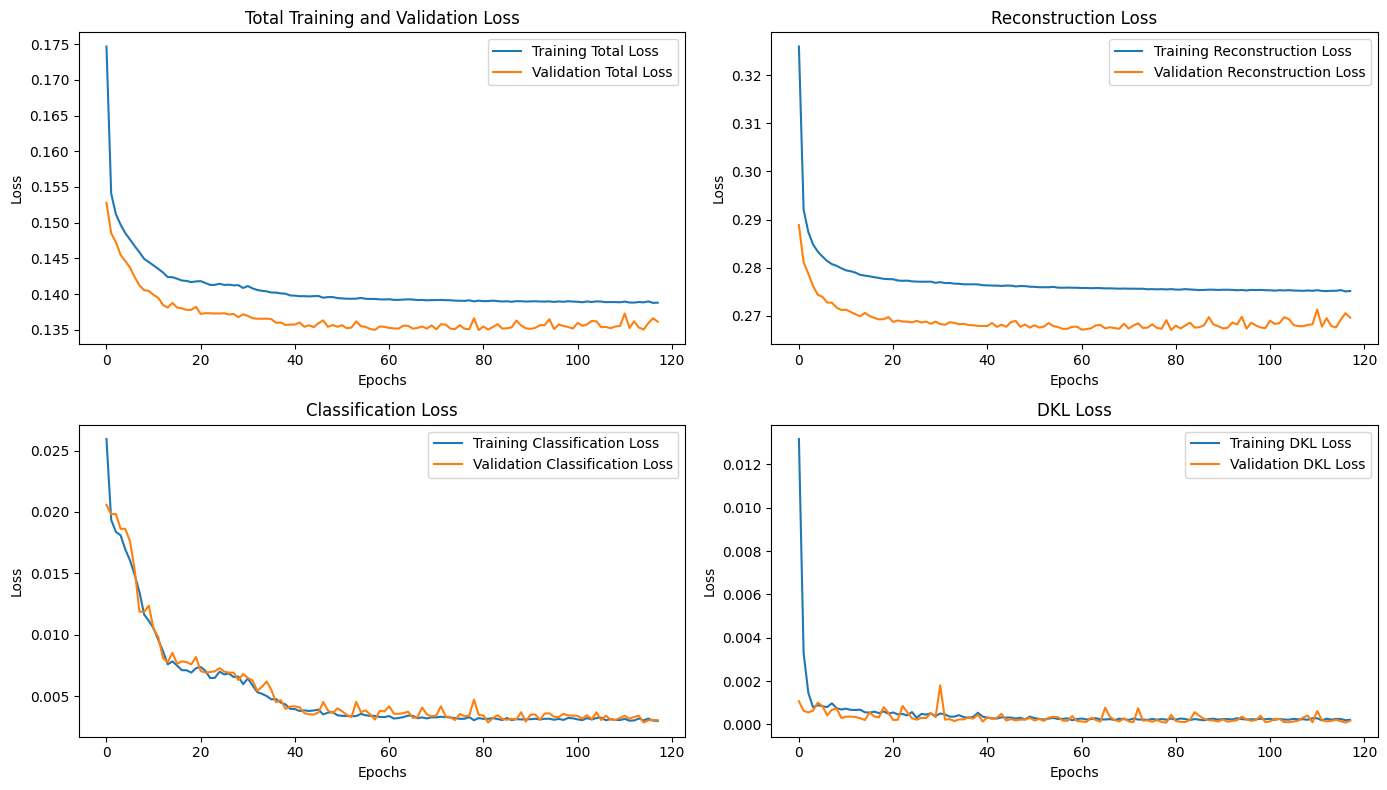

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
reconstruction_loss = history.history['reconstruction_reconstruction_loss']
val_reconstruction_loss = history.history['val_reconstruction_reconstruction_loss']
classification_loss = history.history['softmax_output_mmd_loss']
val_classification_loss = history.history['val_softmax_output_mmd_loss']
dkl_loss = history.history['z_gaussian_dkl_loss']
val_dkl_loss = history.history['val_z_gaussian_dkl_loss']

plt.figure(figsize=(14, 8))

# Gráfico para la pérdida total
plt.subplot(2, 2, 1)
plt.plot(loss, label='Training Total Loss')
plt.plot(val_loss, label='Validation Total Loss')
plt.title('Total Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para la pérdida de reconstrucción
plt.subplot(2, 2, 2)
plt.plot(reconstruction_loss, label='Training Reconstruction Loss')
plt.plot(val_reconstruction_loss, label='Validation Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para la pérdida de clasificación
plt.subplot(2, 2, 3)
plt.plot(classification_loss, label='Training Classification Loss')
plt.plot(val_classification_loss, label='Validation Classification Loss')
plt.title('Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para la pérdida DKL
plt.subplot(2, 2, 4)
plt.plot(dkl_loss, label='Training DKL Loss')
plt.plot(val_dkl_loss, label='Validation DKL Loss')
plt.title('DKL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()